# Word Embeddings and Neural Text Classifiers

This notebook contains three parts as followes:

1. **Word embeddings:** this part provides loading and training word embeddings using the Gensim library.
2. **Introducing neural text classifiers:** this section implemented a neural network classifier using Pytorch for sentiment analysis.
3. **Improving neural text classifiers:** this part improved the model from part 2 using LSTM ang change the parameter in part2.

# Part 1: Word Embeddings

Generate vector representations from sparse vectors and dense word2vec embeddings 

Load the `tweet eval` sentiment dataset

In [1]:
import numpy as np
import torch


%load_ext autoreload
%autoreload 2

In [2]:
from datasets import load_dataset
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer

cache_dir = "./data_cache"

train_dataset = load_dataset(
    "tweet_eval",
    name="sentiment",
    split="train",
    ignore_verifications=True,
    cache_dir=cache_dir,
)

print(f"Training dataset with {len(train_dataset)} instances loaded")


dev_dataset = load_dataset(
    "tweet_eval",
    name="sentiment",
    split="validation",
    ignore_verifications=True,
    cache_dir=cache_dir,
)

print(f"Development/validation dataset with {len(dev_dataset)} instances loaded")


test_dataset = load_dataset(
    "tweet_eval",
    name="sentiment",
    split="test",
    ignore_verifications=True,
    cache_dir=cache_dir,
)

print(f"Test dataset with {len(test_dataset)} instances loaded")

# Put the data into lists ready for the next steps...
train_texts = []
train_labels = []
for i in tqdm(range(len(train_dataset))):
    train_texts.append(train_dataset[i]['text'])
    train_labels.append(train_dataset[i]['label'])
            
# A count vectorizer object may be useful in later steps
vectorizer = CountVectorizer()
vectorizer.fit(train_texts)

# Get the vocabulary
vocab = vectorizer.vocabulary_
vocab_size = len(vocab)
print(f'The vocabulary has {vocab_size} words')

# invert the vocabulary dictionary x
keys = vocab.values()
values = vocab.keys()
vocab_inverted = dict(zip(keys, values))

print(f'Index of "happy" is {vocab["happy"]}')

Reusing dataset tweet_eval (./data_cache/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Training dataset with 45615 instances loaded


Reusing dataset tweet_eval (./data_cache/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Development/validation dataset with 2000 instances loaded


Reusing dataset tweet_eval (./data_cache/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Test dataset with 12284 instances loaded


100%|██████████| 45615/45615 [00:04<00:00, 11209.48it/s]


The vocabulary has 43358 words
Index of "happy" is 17184


## 1.1. Term-Document Matrix



Created a term-document matrix for the training set 

In [3]:
term_doc = vectorizer.fit_transform(train_texts) #Learn the train_texts and return document-term matrix
term = term_doc.toarray().T #change term_doc to array and transpose to be rows is terms, columns is documents 
print(term)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Created a function to returns its term vector from the term-document matrix and Get the term vector for 'happy' 

In [4]:
def find_term(word):
    return [term[vocab[word]]] #use word to find the index in the vocab and then, return the index in term matrix.

vector_happy = find_term('happy') #find the term vector of the word "happy"
print(vector_happy)

[array([0, 0, 0, ..., 0, 0, 0])]


Find the five most similar words to 'happy' using the term vectors

In [5]:
from scipy.spatial.distance import cdist 


# Compute distance between each pair of vector_happy and term by using cdist and choose metric = cosine distance.
five_similar = cdist(vector_happy , term, metric = 'cosine')

#find the index of the most five similar words by sorting five_similar and choose 5 element to be top five
indexs_similar = five_similar[0].argsort()[1:6] #index 0 will be happy(same word) so, it have to choose index from 1-6

#print out the five most similar words to 'happy' 
print("the five most similar words to 'happy' : ")
for index in indexs_similar:
    print(vocab_inverted[index])

the five most similar words to 'happy' : 
birthday
prince
day
you
george


## 1.2 Word Embeddings

Tokenizes the training texts and use Gensim to train a word2vec model

In [6]:
from gensim.models import word2vec
from gensim.utils import tokenize

tokenized_texts = [list(tokenize(text)) for text in train_texts]
emb_model = word2vec.Word2Vec(tokenized_texts, sg=1, min_count=1, window=3, vector_size=100)

In [7]:
# get the word vector for 'happy'
happy_embedding = emb_model.wv['happy']

Find the five most similar words to 'happy' according to your word2vec model. 

In [8]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

similar = emb_model.wv.similar_by_word('happy', 5) #find the five most similar words to 'happy'
print("The five most similar words to 'happy':\n", similar)

The five most similar words to 'happy':
 [('cute', 0.8913638591766357), ('cake', 0.8668360710144043), ('sad', 0.866085946559906), ('cool', 0.8619399070739746), ('sweet', 0.8589187860488892)]


Applied GLoVe to traine on a corpus of tweets (an alternative to the skipgram model)

In [9]:
import gensim.downloader

glove_wv = gensim.downloader.load('glove-twitter-25')

# show the vector for Hamlet:
print(glove_wv['happy'])

[-1.2304   0.48312  0.14102 -0.0295  -0.65253 -0.18554  2.1033   1.7516
 -1.3001  -0.32113 -0.84774  0.41995 -3.8823   0.19638 -0.72865 -0.85273
  0.23174 -1.0763  -0.83023  0.10815 -0.51015  0.27691 -1.1895   0.98094
 -0.13955]


Find the most similar five words to 'happy' according to the GloVe Twitter model. 

In [10]:
similar_glove = glove_wv.similar_by_word('happy', 5) #find the five most similar words to 'happy'
print("The five most similar words to 'happy':\n", similar_glove)

The five most similar words to 'happy':
 [('birthday', 0.9577817320823669), ('thank', 0.937666654586792), ('welcome', 0.9336148500442505), ('love', 0.9176183342933655), ('miss', 0.9164499640464783)]


# 1.3 Tweet Embeddings


Compute average word embeddings for each tweet in the `tokenized_texts` list. 

In [11]:
avg_emb = [] # list to store the average word embeddings for each tweet

for tweet in tokenized_texts: #iterate through the tokenized_texts to get each tweet
    sum_emb = 0
    for word in tweet: #iterate through the tweet to get each word
        sum_emb  += emb_model.wv[word] #sum all of word
    avg = sum_emb/len(tweet) #compute the average
    avg_emb.append(avg) #append it to avg_emb list

In [12]:
avg_emb # the result of average word embeddings for each tweet

[array([-2.42085487e-01,  2.31792614e-01,  1.27274051e-01,  1.86807051e-01,
        -5.12650907e-02, -2.64379144e-01,  1.71675548e-01,  3.50553513e-01,
        -6.00607842e-02, -1.48388073e-01, -2.42516324e-02, -3.16533625e-01,
         1.61296576e-01,  2.64127702e-02,  2.25192368e-01, -2.07669199e-01,
         3.13069671e-03, -1.86198235e-01, -1.48811504e-01, -5.08450627e-01,
         2.72216350e-01,  2.40010425e-01,  4.38788861e-01, -6.05522580e-02,
         4.99747694e-03,  3.33977602e-02, -2.67950654e-01,  8.39701742e-02,
        -1.57337934e-01, -1.11212991e-02,  3.13207954e-01, -1.43446684e-01,
         3.12678516e-01, -3.20564538e-01, -1.84350982e-01,  2.75864333e-01,
         7.55319223e-02,  3.83844110e-03, -2.52469093e-01, -3.41239274e-01,
        -9.86405313e-02, -1.39877498e-01, -1.44128695e-01, -3.38238925e-02,
         1.13529935e-01, -1.25721514e-01, -1.20146647e-01,  1.25669045e-04,
         7.14669824e-02,  2.07907975e-01,  1.00519627e-01, -2.09541634e-01,
        -1.2

Identify a topic name for any of the categories

In [13]:
#choose KMeans to seperate cluster to each class
from sklearn.cluster import KMeans

#initiative KMeans with n_clusters=3
kmeans = KMeans(n_clusters=3, random_state=0)

#fit this model
kmeans.fit(avg_emb)

#make predict
predict_kmeans = kmeans.predict(avg_emb)

In [14]:
predict_kmeans #the result of KMeans

array([1, 1, 0, ..., 1, 0, 1], dtype=int32)

In [15]:
#choose PAC to visulising Embeddings
from sklearn.decomposition import PCA

#initiative KMeans with n_components=4
pca = PCA(n_components=4)

#fit model
pca_result = pca.fit_transform(avg_emb)

In [16]:
pca_result #the result of PAC

array([[ 0.74629463, -0.15223767, -0.05344943,  0.08654822],
       [ 0.36543997,  0.14671802, -0.2688418 , -0.05300942],
       [-0.2698432 ,  0.36401987, -0.17354862,  0.01203958],
       ...,
       [ 0.54763171, -0.14555999,  0.12971733, -0.17383556],
       [-0.19833602,  0.295089  , -0.13480291, -0.01679491],
       [ 0.54834631, -0.20749608,  0.17280192, -0.15231392]])

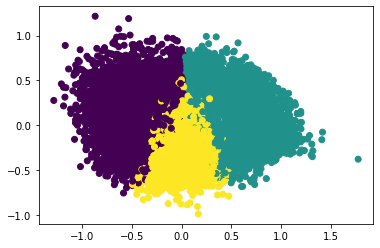

In [17]:
#plot the PCA result
import matplotlib.pyplot as plt #import matplotlib

#plot result in scatter plot and colour each class by KMeans 
plt.scatter(pca_result[:,0], pca_result[:,1], c = predict_kmeans)

In [18]:
#find the label in kmean 
label_class = kmeans.labels_

#tokenize tokenized_texts
sentence = np.array(tokenized_texts)

#extract word which belong to each topic and store in the list
topic_label0 = [word for tweet in sentence[label_class == 0] for word in tweet]
topic_label1 = [word for tweet in sentence[label_class == 1] for word in tweet]
topic_label2 = [word for tweet in sentence[label_class == 2] for word in tweet]  

<ipython-input-18-b90819e89f84>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sentence = np.array(tokenized_texts)


In [19]:
import nltk
>>> nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gracepichar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [20]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')) #import stop words

In [21]:
dict_topic0 = {} #topic0
dict_topic1 = {} #topic1
dict_topic2 = {} #topic2

#create dict for topic0
for word in topic_label0:
    if (word.lower() not in stop_words): #remove stop word
        if (word in dict_topic0):
            dict_topic0[word] = dict_topic0[word]+1
        else:
            dict_topic0[word] = 1

#create dict for topic1
for word in topic_label1:
    if (word.lower() not in stop_words): #remove stop word
        if (word in dict_topic1):
            dict_topic1[word] = dict_topic1[word]+1
        else:
            dict_topic1[word] = 1

#create dict for topic2
for word in topic_label2:
    if (word.lower() not in stop_words): #remove stop word
        if (word in dict_topic2):
            dict_topic2[word] = dict_topic2[word]+1
        else:
            dict_topic2[word] = 1

#sort dictionary topic0,1,2
dict_topic0_sort = sorted(dict_topic0.items(), key = lambda value: value[1], reverse = True)
dict_topic1_sort = sorted(dict_topic1.items(), key = lambda value: value[1], reverse = True) 
dict_topic2_sort = sorted(dict_topic2.items(), key = lambda value: value[1], reverse = True) 

#find the most five similar word
similar_topic0 = [word[0] for word in dict_topic0_sort[0:5]]
similar_topic1 = [word[0] for word in dict_topic1_sort[0:5]]
similar_topic2 = [word[0] for word in dict_topic2_sort[0:5]]

In [22]:
#print the most five similar word of each topic
print("The five similar word in topic 0:", ', '.join(similar_topic0)) 
print("The five similar word in topic 1:", ', '.join(similar_topic1))
print("The five similar word in topic 2:", ', '.join(similar_topic2))

The five similar word in topic 0: user, u, tomorrow, may, going
The five similar word in topic 1: u, user, c, th, tomorrow
The five similar word in topic 2: user, may, th, st, tomorrow


# Part 2: Introducing Neural Text Classifiers 

Implement a neural network classifier using Pytorch

Map the tokens to their IDs

In [23]:
# tokenize training set and convert to input IDs.
def encode_text(sample):
    tokens = tokenize(sample['text'])  # Tokenize one document
    
    input_ids = []
    for token in tokens:
        if str.lower(token) in vocab:  # Skip words from the dev/test set that are not in the vocabulary.
            input_ids.append(vocab[str.lower(token)]+1) # +1 is needed because we reserve 0 as a special character
            
    sample['input_ids'] = input_ids 
    return sample

# The map method of the dataset object takes a function as its argument, 
# and applies that function to each document in the dataset.
train_dataset = train_dataset.map(encode_text)
len(train_dataset)

Loading cached processed dataset at ./data_cache/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343/cache-cd3519d148100869.arrow


45615

Plot a histogram to show the length distribution of the texts

Mean of the document length: 18.160166611860134
Median of the document length: 18.0
Maximum document length: 32


(array([   21.,   522.,  2430.,  4908.,  7772., 11003., 10389.,  6738.,
         1719.,   113.]),
 array([ 1. ,  4.1,  7.2, 10.3, 13.4, 16.5, 19.6, 22.7, 25.8, 28.9, 32. ]),
 <BarContainer object of 10 artists>)

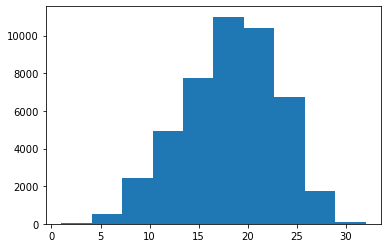

In [24]:
import matplotlib.pyplot as plt

rv_l = [len(doc) for doc in train_dataset['input_ids']]
print('Mean of the document length: {}'.format(np.mean(rv_l)))
print('Median of the document length: {}'.format(np.median(rv_l)))
print('Maximum document length: {}'.format(np.max(rv_l)))

plt.hist(rv_l)

Pad the documents that are shorter than this maximum by adding 0s to the start of the sequence. Any documents that exceed the length will be truncated



In [25]:
sequence_length = 40  # truncate all docs longer than this. Pad all docs shorter than this.

def pad_text(sample):
    id_texts = sample['input_ids'] #extract id in the dictionary sample
    id_len = len(id_texts) #find the len of text
    padding = [0]*(sequence_length-id_len) + id_texts[:sequence_length] #insret 0 at the start for too short and truncate for too long
    sample['input_ids'] = padding
    print(sample)
    return sample

# The map method will call pad_text for every document in the dataset
train_dataset = train_dataset.map(pad_text)

Loading cached processed dataset at ./data_cache/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343/cache-35542d7607a5c67c.arrow


Wrap our dataset in a [DataLoader object](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader). 

In [26]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 64

# convert from the Huggingface format to a TensorDataset so we can use the mini-batch sampling functionality
def convert_to_data_loader(dataset, num_classes):
    # convert from list to tensor
    input_tensor = torch.from_numpy(np.array(dataset['input_ids']))
    label_tensor = torch.from_numpy(np.array(dataset['label'])).long()
    tensor_dataset = TensorDataset(input_tensor, label_tensor)
    loader = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True)

    return loader

num_classes = len(np.unique(train_labels))   # number of possible labels in the sentiment analysis task

train_loader = convert_to_data_loader(train_dataset, num_classes)

Process the development and test set 

In [27]:
dev_dataset = dev_dataset.map(encode_text)
dev_dataset = dev_dataset.map(pad_text)
dev_loader = convert_to_data_loader(dev_dataset, num_classes)

test_dataset = test_dataset.map(encode_text)
test_dataset = test_dataset.map(pad_text)
test_loader = convert_to_data_loader(test_dataset, num_classes)

Loading cached processed dataset at ./data_cache/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343/cache-062028beafdcab63.arrow
Loading cached processed dataset at ./data_cache/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343/cache-7e6a31472820cbbc.arrow
Loading cached processed dataset at ./data_cache/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343/cache-263d9c88c364ad8f.arrow
Loading cached processed dataset at ./data_cache/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343/cache-a2d388f2b6fa33f4.arrow


Construced the NN with three layers 

In [28]:
from torch import nn

class FFTextClassifier(nn.Module):
    
    def __init__(self, vocab_size, sequence_length, embedding_size, hidden_size, num_classes):
        super(FFTextClassifier, self).__init__()

        self.embedding_size = embedding_size

        # Here we just need to construct the components of our network. We don't need to connect them together yet.
        self.embedding_layer = nn.Embedding(vocab_size, embedding_size) # embedding layer
        self.hidden_layer = nn.Linear(embedding_size*sequence_length, hidden_size) # Hidden layer
        self.activation = nn.ReLU() # Hidden layer
        self.output_layer = nn.Linear(hidden_size, num_classes) # Fully connected layer
        
       
        
        
    def forward (self, input_words):
        # Input dimensions are:  (batch_size, seq_length)
        embedded_words = self.embedding_layer(input_words)  # (batch_size, seq_length, embedding_size)
        
        # flatten the sequence of embedding vectors for each document into a single vector.
        embedded_words = embedded_words.reshape(embedded_words.shape[0], sequence_length*self.embedding_size)  # batch_size, seq_length*embedding_size

        
        hidden = self.hidden_layer(embedded_words) #assign hidden layer with embedded_words to hidden 
        h = self.activation(hidden)#comput h from activation


        output = self.output_layer(h)                      # (batch_size, num_classes)

        
      
        return output

Create a NN with the FFTextClassifier class

In [29]:
vocab_size = len(vectorizer.vocabulary_) + 1
embedding_size = 10  # number of dimensions for embeddings
hidden_size = 8 # number of hidden units


model = FFTextClassifier(vocab_size, sequence_length ,embedding_size, hidden_size, num_classes)

Built a training function to calculate the loss for each input and perform backpropagation to optimise the network

In [30]:
from torch import optim

def train_nn(num_epochs, model, train_dataloader, dev_dataloader):
    
    learning_rate = 0.0005  # learning rate for the gradient descent optimizer, related to the step size

    loss_fn = nn.CrossEntropyLoss()  # create loss function object
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # create the optimizer
    
    for e in range(num_epochs):
        # Track performance on the training set as we are learning...
        total_correct = 0
        total_trained = 0
        train_losses = []

        model.train()  # Put the model in training mode.

        for i, (batch_input_ids, batch_labels) in enumerate(train_dataloader):
            # Iterate over each batch of data
            # print(f'batch no. = {i}')

            optimizer.zero_grad()  # Reset the optimizer

            # Use the model to perform forward inference on the input data.
            # This will run the forward() function.
            output = model(batch_input_ids)

            # Compute the loss for the current batch of data
            batch_loss = loss_fn(output, batch_labels)

            # Perform back propagation to compute the gradients with respect to each weight
            batch_loss.backward()

            # Update the weights using the compute gradients
            optimizer.step()

            # Record the loss from this sample to keep track of progress.
            train_losses.append(batch_loss.item())

            # Count correct labels so we can compute accuracy on the training set
            predicted_labels = output.argmax(1)
            total_correct += (predicted_labels == batch_labels).sum().item()
            total_trained += batch_labels.size(0)

        train_accuracy = total_correct/total_trained*100

        print("Epoch: {}/{}".format((e+1), num_epochs),
              "Training Loss: {:.4f}".format(np.mean(train_losses)),
              "Training Accuracy: {:.4f}%".format(train_accuracy))

        model.eval()  # Switch model to evaluation mode
        total_correct = 0
        total_trained = 0
        dev_losses = []

        for dev_input_ids, dev_labels in dev_dataloader:
            
           
            #perform forward inference on dev_input_ids
            dev_output = model(dev_input_ids)
            
            #Compute the loss 
            dev_loss = loss_fn(dev_output, dev_labels)
            

            # Save the loss on the dev set
            dev_losses.append(dev_loss.item())

            # Count the number of correct predictions
            predicted_labels = dev_output.argmax(1)
            total_correct += (predicted_labels == dev_labels).sum().item()
            total_trained += dev_labels.size(0)
            
        dev_accuracy = total_correct/total_trained*100
        
        print("Epoch: {}/{}".format((e+1), num_epochs),
              "Validation Loss: {:.4f}".format(np.mean(dev_losses)),
              "Validation Accuracy: {:.4f}%".format(dev_accuracy))
    return model

Train the network for 10 epochs

In [31]:
train_nn1 = train_nn(10, model, train_loader, dev_loader)

Epoch: 1/10 Training Loss: 1.0131 Training Accuracy: 44.9655%
Epoch: 1/10 Validation Loss: 1.0086 Validation Accuracy: 43.2000%
Epoch: 2/10 Training Loss: 1.0038 Training Accuracy: 45.5837%
Epoch: 2/10 Validation Loss: 1.0143 Validation Accuracy: 43.2500%
Epoch: 3/10 Training Loss: 0.9928 Training Accuracy: 46.5483%
Epoch: 3/10 Validation Loss: 1.0074 Validation Accuracy: 43.8500%
Epoch: 4/10 Training Loss: 0.9755 Training Accuracy: 48.0588%
Epoch: 4/10 Validation Loss: 1.0024 Validation Accuracy: 45.1500%
Epoch: 5/10 Training Loss: 0.9504 Training Accuracy: 51.0205%
Epoch: 5/10 Validation Loss: 0.9951 Validation Accuracy: 46.4500%
Epoch: 6/10 Training Loss: 0.9221 Training Accuracy: 53.6709%
Epoch: 6/10 Validation Loss: 0.9827 Validation Accuracy: 48.8000%
Epoch: 7/10 Training Loss: 0.8924 Training Accuracy: 56.2183%
Epoch: 7/10 Validation Loss: 0.9671 Validation Accuracy: 51.8000%
Epoch: 8/10 Training Loss: 0.8644 Training Accuracy: 58.2703%
Epoch: 8/10 Validation Loss: 0.9599 Valida

Evaluate the model on test set using the function below

In [32]:
def predict_nn(trained_model, test_loader):

    trained_model.eval()

    correct = 0  # count the number of correct classification labels

    gold_labs = []  # gold labels to return
    pred_labs = []  # predicted labels to return
    
    for inputs, labels in test_loader:
        test_output = trained_model(inputs)
        predicted_labels = test_output.argmax(1)

        gold_labs.extend(labels.tolist())
        pred_labs.extend(predicted_labels.tolist())
    
    return gold_labs, pred_labs

gold_labs, pred_labs = predict_nn(train_nn1, test_loader)


from sklearn.metrics import classification_report #import classification_report to measure of performance 

print(classification_report(gold_labs, pred_labs))

              precision    recall  f1-score   support

           0       0.59      0.23      0.33      3972
           1       0.54      0.73      0.62      5937
           2       0.41      0.46      0.43      2375

    accuracy                           0.52     12284
   macro avg       0.51      0.47      0.46     12284
weighted avg       0.53      0.52      0.49     12284



Converts the GloVe embeddings into an embedding matrix suitable for PyTorch

In [33]:
embedding_matrix = torch.zeros((vocab_size, glove_wv.vector_size))
for word in vocab:
    word_idx = vocab[word]
    if word in glove_wv:
        embedding_matrix[word_idx, :] = torch.from_numpy(glove_wv[word])
        
print(embedding_matrix)

<ipython-input-33-68f316c0ea6c>:5: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/pytorch/torch/csrc/utils/tensor_numpy.cpp:178.)
  embedding_matrix[word_idx, :] = torch.from_numpy(glove_wv[word])


tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.3535,  0.0987,  0.1718,  ...,  0.4630,  1.3101,  1.1314],
        [-0.4106,  0.1487,  0.0637,  ...,  0.6097,  1.0935,  0.9614],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


Set the dimensions of the neural network layers and repeat the experiment above using the FFTextClassifierWithEmbeddings with the GLoVe embeddings to compare the performance of the two neural text classifiers

In [100]:
import gensim.downloader


class FFTextClassifierWithEmbeddings(FFTextClassifier):

    def __init__(self, hidden_size, num_classes):
        super(FFTextClassifier, self).__init__()

        self.embedding_size = embedding_matrix.shape[1] 

        # Here we just need to construct the components of our network. We don't need to connect them together yet.
        self.embedding_layer = nn.Embedding.from_pretrained(embedding_matrix, freeze=True) # embedding layer

        ### COMPLETE THE ARGUMENTS TO SPECIFY THE DIMENSIONS OF THE LAYERS
        self.hidden_layer = nn.Linear(embedding_matrix.shape[1]*sequence_length, hidden_size) # Hidden layer
        self.activation = nn.ReLU() # Hidden layer
        self.output_layer = nn.Linear(hidden_size,sequence_length ,num_classes) # Full connection layer

In [35]:
#create the model of this task
model2 = FFTextClassifierWithEmbeddings(hidden_size ,num_classes)
#train the model for 10 epochs
train_nn2 = train_nn(10, model2, train_loader, dev_loader)

Epoch: 1/10 Training Loss: 1.4075 Training Accuracy: 44.0798%
Epoch: 1/10 Validation Loss: 1.0372 Validation Accuracy: 46.3000%
Epoch: 2/10 Training Loss: 1.0015 Training Accuracy: 48.7625%
Epoch: 2/10 Validation Loss: 1.0078 Validation Accuracy: 46.8000%
Epoch: 3/10 Training Loss: 0.9798 Training Accuracy: 49.7775%
Epoch: 3/10 Validation Loss: 1.0037 Validation Accuracy: 47.9500%
Epoch: 4/10 Training Loss: 0.9707 Training Accuracy: 50.0712%
Epoch: 4/10 Validation Loss: 0.9922 Validation Accuracy: 47.6000%
Epoch: 5/10 Training Loss: 0.9631 Training Accuracy: 50.5996%
Epoch: 5/10 Validation Loss: 0.9969 Validation Accuracy: 47.7500%
Epoch: 6/10 Training Loss: 0.9572 Training Accuracy: 51.0337%
Epoch: 6/10 Validation Loss: 0.9975 Validation Accuracy: 46.9500%
Epoch: 7/10 Training Loss: 0.9511 Training Accuracy: 51.4831%
Epoch: 7/10 Validation Loss: 0.9975 Validation Accuracy: 47.3000%
Epoch: 8/10 Training Loss: 0.9468 Training Accuracy: 51.6913%
Epoch: 8/10 Validation Loss: 0.9987 Valida

In [36]:
#make predict
gold_labs2, pred_labs2 = predict_nn(train_nn2, test_loader)
#evaluate the performance of model
print(classification_report(gold_labs2, pred_labs2))

              precision    recall  f1-score   support

           0       0.58      0.09      0.16      3972
           1       0.49      0.69      0.58      5937
           2       0.28      0.39      0.32      2375

    accuracy                           0.44     12284
   macro avg       0.45      0.39      0.35     12284
weighted avg       0.48      0.44      0.39     12284



**Answer: The perfomance of the FFTextClassifierWithEmbeddings model is lower than the FFTextClassifier(the previous one). It can be seen from the  f1-score macro avg which FFTextClassifierWithEmbeddings = 0.35 and FFTextClassifier = 0.46 because the embeddings is fixed to the pretrained values so, it can not update weights through backpropagation for fitting with dataset in the process**

# Part 3: Improving the Neural Text Classifier

**Due to The limitations of the neural text classifier with the following:**  
1. All data should be input at the same time and it process all of the word in the same time, however the document contains a large number of words.       
2. The weights which apply to the input position are affected based on the index of each word in the input; for example," On Friday, it was raining"  and "It was raining on Friday", the weights apply with different weights    
3.The process of lerning complex and too many parameters to optimize so, it make that the scalability of this model is quit  problematic 

**The impovement:**   
1. Chage the parameter; freeze=False. it can update the parameter's weight through backpropagation so, the accuracy and f1 score will improve.   
2. To improve those limitation of this model, it will apply the lstm model. This model can process the important long-distance information and have a long term memory. Moreover,this model is capable of storing and recalling relevant information which can kept and get rid of the irlrvent information in each cell, as well as identifying a recurring pattern.

# 1. Chage the parameter; freeze=True

In [98]:
class FFTextClassifierWithEmbeddings2(FFTextClassifier):

    def __init__(self, hidden_size, num_classes):
        super(FFTextClassifier, self).__init__()

        self.embedding_size = embedding_matrix.shape[1] 

        #change freeze=False, it can update the parameter's weight
        self.embedding_layer = nn.Embedding.from_pretrained(embedding_matrix, freeze=False) # embedding layer

        ### COMPLETE THE ARGUMENTS TO SPECIFY THE DIMENSIONS OF THE LAYERS
        self.hidden_layer = nn.Linear(embedding_matrix.shape[1]*sequence_length, hidden_size) # Hidden layer
        self.activation = nn.ReLU() # Hidden layer
        self.output_layer = nn.Linear(hidden_size,sequence_length ,num_classes) # Full connection layer

In [99]:
model4 =  FFTextClassifierWithEmbeddings2(hidden_size ,num_classes)

In [39]:
train_nn4 = train_nn(10, model4, train_loader, dev_loader)

Epoch: 1/10 Training Loss: 1.2878 Training Accuracy: 44.7528%
Epoch: 1/10 Validation Loss: 0.9943 Validation Accuracy: 48.6500%
Epoch: 2/10 Training Loss: 0.9414 Training Accuracy: 54.5303%
Epoch: 2/10 Validation Loss: 0.9405 Validation Accuracy: 54.9500%
Epoch: 3/10 Training Loss: 0.8593 Training Accuracy: 60.1491%
Epoch: 3/10 Validation Loss: 0.8876 Validation Accuracy: 58.6500%
Epoch: 4/10 Training Loss: 0.7869 Training Accuracy: 64.0557%
Epoch: 4/10 Validation Loss: 0.8546 Validation Accuracy: 61.1000%
Epoch: 5/10 Training Loss: 0.7292 Training Accuracy: 67.5501%
Epoch: 5/10 Validation Loss: 0.8505 Validation Accuracy: 61.4500%
Epoch: 6/10 Training Loss: 0.6809 Training Accuracy: 70.2313%
Epoch: 6/10 Validation Loss: 0.8445 Validation Accuracy: 62.1000%
Epoch: 7/10 Training Loss: 0.6372 Training Accuracy: 72.6888%
Epoch: 7/10 Validation Loss: 0.8276 Validation Accuracy: 63.5000%
Epoch: 8/10 Training Loss: 0.5968 Training Accuracy: 74.9644%
Epoch: 8/10 Validation Loss: 0.8435 Valida

In [40]:
#make predict
gold_labs4, pred_labs4 = predict_nn(train_nn4, test_loader)
#evaluate the performance of model
print(classification_report(gold_labs4, pred_labs4))

              precision    recall  f1-score   support

           0       0.63      0.38      0.48      3972
           1       0.59      0.68      0.63      5937
           2       0.48      0.60      0.53      2375

    accuracy                           0.57     12284
   macro avg       0.56      0.55      0.55     12284
weighted avg       0.58      0.57      0.56     12284



**The f1 macro improve to 0.55** 

# 2. Using LSTM

In [94]:
import torch.nn.functional as F

class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim
        
        # embedding layer
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        
        # the input of model is word embedding
        #set the parameter num_layers(number of hidden nodes) = 2
        #use Bi-directional LSTM by setting bidirectional = True
        #set the dropout layer to apply the outputs of each layer by dropout=0.1
        self.lstm = nn.LSTM(embedding_dim*sequence_length, hidden_dim, num_layers=2, 
                            bidirectional=True, dropout=0.1)
        
        #the dropout layer
        self.drop = nn.Dropout(p = 0.8)
        
        # Set The linear layer 
        self.hidden2tag = nn.Linear(hidden_dim*2, tagset_size)
        self.activation = nn.ReLU() #set the activation function
        
    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [95]:
model7 = LSTMTagger(embedding_size, hidden_size, vocab_size, num_classes)

In [96]:
train_nn7 = train_nn(10, model7, train_loader, dev_loader)

Epoch: 1/10 Training Loss: 1.0200 Training Accuracy: 44.5555%
Epoch: 1/10 Validation Loss: 1.0182 Validation Accuracy: 43.4500%
Epoch: 2/10 Training Loss: 1.0126 Training Accuracy: 45.2461%
Epoch: 2/10 Validation Loss: 1.0210 Validation Accuracy: 43.4500%
Epoch: 3/10 Training Loss: 1.0094 Training Accuracy: 45.3206%
Epoch: 3/10 Validation Loss: 1.0121 Validation Accuracy: 43.5000%
Epoch: 4/10 Training Loss: 1.0049 Training Accuracy: 45.3097%
Epoch: 4/10 Validation Loss: 1.0194 Validation Accuracy: 43.4500%
Epoch: 5/10 Training Loss: 0.9955 Training Accuracy: 45.5004%
Epoch: 5/10 Validation Loss: 1.0116 Validation Accuracy: 43.4000%
Epoch: 6/10 Training Loss: 0.9806 Training Accuracy: 46.3685%
Epoch: 6/10 Validation Loss: 0.9997 Validation Accuracy: 44.6000%
Epoch: 7/10 Training Loss: 0.9595 Training Accuracy: 48.3109%
Epoch: 7/10 Validation Loss: 0.9938 Validation Accuracy: 46.5000%
Epoch: 8/10 Training Loss: 0.9375 Training Accuracy: 50.4110%
Epoch: 8/10 Validation Loss: 0.9940 Valida

In [97]:
#make predict
gold_labs7, pred_labs7 = predict_nn(train_nn7, test_loader)
#evaluate the performance of model
print(classification_report(gold_labs7, pred_labs7))

              precision    recall  f1-score   support

           0       0.59      0.14      0.23      3972
           1       0.50      0.77      0.61      5937
           2       0.33      0.30      0.32      2375

    accuracy                           0.48     12284
   macro avg       0.47      0.41      0.38     12284
weighted avg       0.50      0.48      0.43     12284



**The macro f1 score improve slightly to 0.38**

# 3. Try to change some parameter value

In [133]:
import torch.nn.functional as F

class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # set drop out to be 0.2
        self.lstm = nn.LSTM(embedding_dim*sequence_length, hidden_dim, num_layers=2, 
                            bidirectional=True, dropout=0.2)
        # set p to be 0.3
        self.drop = nn.Dropout(p = 0.3)
        # The linear layer 
        self.hidden2tag = nn.Linear(hidden_dim*2, tagset_size)
        self.activation = nn.Sigmoid() #change activation function
        
    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [134]:
model8 = LSTMTagger(embedding_size, hidden_size, vocab_size, num_classes)

In [135]:
train_nn8 = train_nn(10, model8, train_loader, dev_loader)

Epoch: 1/10 Training Loss: 1.0159 Training Accuracy: 44.9392%
Epoch: 1/10 Validation Loss: 1.0149 Validation Accuracy: 43.5000%
Epoch: 2/10 Training Loss: 1.0113 Training Accuracy: 45.2943%
Epoch: 2/10 Validation Loss: 1.0098 Validation Accuracy: 43.4500%
Epoch: 3/10 Training Loss: 1.0070 Training Accuracy: 45.2636%
Epoch: 3/10 Validation Loss: 1.0119 Validation Accuracy: 43.4500%
Epoch: 4/10 Training Loss: 1.0011 Training Accuracy: 45.8490%
Epoch: 4/10 Validation Loss: 1.0085 Validation Accuracy: 42.8000%
Epoch: 5/10 Training Loss: 0.9895 Training Accuracy: 47.1029%
Epoch: 5/10 Validation Loss: 1.0127 Validation Accuracy: 44.3000%
Epoch: 6/10 Training Loss: 0.9709 Training Accuracy: 49.2119%
Epoch: 6/10 Validation Loss: 1.0029 Validation Accuracy: 46.5500%
Epoch: 7/10 Training Loss: 0.9491 Training Accuracy: 51.2068%
Epoch: 7/10 Validation Loss: 0.9980 Validation Accuracy: 47.7500%
Epoch: 8/10 Training Loss: 0.9249 Training Accuracy: 53.1273%
Epoch: 8/10 Validation Loss: 0.9922 Valida

In [136]:
#make predict
gold_labs8, pred_labs8 = predict_nn(train_nn8, test_loader)
#evaluate the performance of model
print(classification_report(gold_labs8, pred_labs8))

              precision    recall  f1-score   support

           0       0.58      0.10      0.17      3972
           1       0.51      0.77      0.61      5937
           2       0.29      0.32      0.30      2375

    accuracy                           0.46     12284
   macro avg       0.46      0.39      0.36     12284
weighted avg       0.49      0.46      0.41     12284



**The macro f1 score was reduce to 0.36 so, it is incorrectly way**

# 4. Add the hidden layer

In [146]:
import torch.nn.functional as F

class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim
        
        # embedding layer
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        
        # the input of model is word embedding
        #set the parameter num_layers(number of hidden nodes) = 2
        #use Bi-directional LSTM by setting bidirectional = True
        #set the dropout layer to apply the outputs of each layer by dropout=0.1
        self.lstm = nn.LSTM(embedding_dim*sequence_length, hidden_dim, num_layers=2, 
                            bidirectional=True, dropout=0.1)
        
        #the dropout layer
        self.drop = nn.Dropout(p = 0.8)
        
        # Set The linear layer 
        self.activation = nn.ReLU() #set the activation function
        # Set The linear layer 
        #add more hidden layer
        self.hidden1tag = nn.Linear(self.hidden_dim, hidden_dim*2)#add more hidden layer
        self.hidden2tag = nn.Linear(hidden_dim*2, tagset_size)
        
    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [147]:
model9 = LSTMTagger(embedding_size, hidden_size, vocab_size, num_classes)

In [148]:
train_nn9 = train_nn(10, model9, train_loader, dev_loader)

Epoch: 1/10 Training Loss: 1.0182 Training Accuracy: 44.9611%
Epoch: 1/10 Validation Loss: 1.0188 Validation Accuracy: 43.6500%
Epoch: 2/10 Training Loss: 1.0123 Training Accuracy: 45.4324%
Epoch: 2/10 Validation Loss: 1.0128 Validation Accuracy: 43.4500%
Epoch: 3/10 Training Loss: 1.0090 Training Accuracy: 45.4785%
Epoch: 3/10 Validation Loss: 1.0115 Validation Accuracy: 43.8000%
Epoch: 4/10 Training Loss: 1.0035 Training Accuracy: 45.7350%
Epoch: 4/10 Validation Loss: 1.0070 Validation Accuracy: 45.2000%
Epoch: 5/10 Training Loss: 0.9932 Training Accuracy: 46.9495%
Epoch: 5/10 Validation Loss: 1.0078 Validation Accuracy: 43.5500%
Epoch: 6/10 Training Loss: 0.9771 Training Accuracy: 49.2623%
Epoch: 6/10 Validation Loss: 1.0097 Validation Accuracy: 45.9000%
Epoch: 7/10 Training Loss: 0.9567 Training Accuracy: 51.5488%
Epoch: 7/10 Validation Loss: 1.0049 Validation Accuracy: 46.4000%
Epoch: 8/10 Training Loss: 0.9316 Training Accuracy: 53.8288%
Epoch: 8/10 Validation Loss: 1.0085 Valida

In [149]:
#make predict
gold_labs9, pred_labs9 = predict_nn(train_nn9, test_loader)
#evaluate the performance of model
print(classification_report(gold_labs9, pred_labs9))

              precision    recall  f1-score   support

           0       0.58      0.13      0.21      3972
           1       0.51      0.66      0.58      5937
           2       0.29      0.46      0.36      2375

    accuracy                           0.45     12284
   macro avg       0.46      0.42      0.38     12284
weighted avg       0.49      0.45      0.41     12284



**The macro f1 score increase to 0.38**